# CNN Training

Target of this code is to train a CNN network to extract the needle position of an analog needle device.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
import os
import matplotlib.pyplot as plt
import glob
from PIL import Image
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten
%matplotlib inline

### Load training data
* The data is expected in the "Input_dir"
* Picture size must be 32x32 with 3 color channels (RGB)
* The filename contains the informations needed for training:
* Typical filename: 
    * ReadOut-xx_Watch-y_zzzz.jpg 
    * e.g. "ReadOut-54_Watch-4_1667.jpg"

|Place holder | Meaning                     | Usage        |
|------------- |-----------------------------|--------------|
| **xx**          | readout value               | **to be learned** |
| y           | different analog watches    | ignored      |
| zzzz        | running number              | not needed   |

* The images are stored in the x_data[]
* The expected output for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) as the filenames are on order due to the encoding of the expected analog readout in the filename 


In [2]:
Input_dir='data_resize_all'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

for aktfile in files:
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    test_image = np.reshape(test_image, (32,32,3))
    test_image /= 255
    base = os.path.basename(aktfile)
    zahl = (int(base[8:10])) / 100
    x_data.append(test_image)
    zw = np.array([zahl])
    y_data.append(zw)

x_data = np.array(x_data)
y_data = np.array(y_data)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

(2883, 32, 32, 3)
(2883, 1)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 32, 3)
* Shape of the output layer: (1)



In [3]:
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(32,32,3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(Conv2D(16, (5, 5), padding='same'))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(Conv2D(16, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(1))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          12816     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 16)          2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 16)          0         
_________________________________________________________________
flat

### Training

After compiling the net the fitting is done. The learning result is stored in history to visualize the results later on.

* As the target is a number value, the **Mean Squared Error** ist choosen als loss function.
* Batch size and epochs are parameters to play with



In [ ]:
model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adadelta(), metrics = ["accuracy"])

history = model.fit(x_data, y_data, batch_size=8, epochs=100, validation_split=0.2, verbose=1)

### Learing result
 
* Visualization of the training and validation results

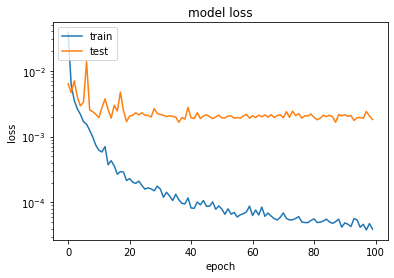

In [5]:
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [9]:
model.save("Analog-Needle-Readout_trained_model_100cyc.h5")

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* This can be copied to e.g. Excel to check if the needed accuracy is acceptable

In [ ]:
Input_dir='data_resize_all'

files = glob.glob(Input_dir + '/*.*')

for aktfile in files:
    base = os.path.basename(aktfile)
    zahl = (int(base[8:10])) / 100
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    test_image = test_image/255
    img = np.reshape(test_image,[1,32,32,3])
    classes = model.predict(img)
    print(base, ', ', zahl, ', ', round(classes[0][0], 2), ', ', round(classes[0][0] - zahl, 2))